# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [21]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
import os
from skimage.transform import resize
from random import shuffle
import pandas as pd
import cv2
from collections import Counter
from skimage import exposure

data_dir = './data'

In [22]:
import pickle

# TODO: Fill this in based on where you saved the training and testing data
traffic_signs_data_dir = "%s/traffic-signs-data" % data_dir
training_file =  '%s/train.p' % traffic_signs_data_dir
validation_file = '%s/valid.p' % traffic_signs_data_dir
testing_file = '%s/test.p' % traffic_signs_data_dir
    
# Load pickled data
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

In [23]:
signnames_pd = pd.read_csv('signnames.csv')
#signnames_pd.head()

In [24]:
def signname_val_to_name(signnames_pd, val):
    return signnames_pd[signnames_pd['ClassId'] == val]['SignName'].values[0]

In [25]:
def shuffle_X_y(X, y):
    idxs = [i for i in range(X.shape[0])]
    shuffle(idxs)
    
    return X[idxs], y[idxs]

In [26]:
def make_label_image_dict(X, y):
    image_dict = {}
    
    for i in range(X.shape[0]):
        curr_image = X[i]
        curr_y = y[i]
        
        if curr_y in image_dict:
            image_dict[curr_y].append(curr_image)
        else:
            image_dict[curr_y] = [curr_image]
    
    return image_dict

In [27]:
def filter_images_by_label(label, X=None, y=None, label_image_dict=None):
    assert (X is not None and y is not None) or (label_image_dict is not None)
    
    filtered_image_arr = []

    """
    for i in range(X.shape[0]):
        if y[i] == label:
            filtered_image_arr.append(X[i])
    """
    
    if label_image_dict is None:
        label_image_dict = make_label_image_dict(X, y) 
        
    if label in label_image_dict:
        filtered_image_arr = label_image_dict[label]    
        return np.stack(filtered_image_arr)
    else:
        return None

In [28]:
def apply_to_layers(image, apply_fnc):
    image_arr = [apply_fnc(image[i]) for i in range(image.shape[0])]
    
    return np.stack(image_arr)

In [29]:
import warnings

def apply_histogram_equalization(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_image = gray_image.astype(np.float32)/255.0
    assert gray_image.min() >= 0 and gray_image.max() <= 255
    
    warnings.filterwarnings("ignore")
    equalized_image = exposure.equalize_adapthist(gray_image)
    warnings.resetwarnings()

    equalized_image = (255.0*equalized_image).astype(np.uint8)
    assert equalized_image.min() >= 0 and equalized_image.max() <= 255
    
    return equalized_image

In [30]:
apply_histogram_equalization(X_train[3])

array([[68, 34, 51, ..., 55, 51, 51],
       [51, 34, 34, ..., 72, 51, 51],
       [51, 34, 17, ..., 55, 68, 34],
       ..., 
       [46, 46, 29, ..., 31, 34, 34],
       [51, 51, 34, ..., 17, 17, 17],
       [51, 34, 17, ..., 34, 34, 34]], dtype=uint8)

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [31]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = (X_train.shape[1], X_train.shape[2])

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train.reshape((-1)).tolist()))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [32]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

In [33]:
def display_X_y_images(X, y=None, signnames_pd=None, start_idx=0, end_idx=None, 
                       columns = 5, use_gray=False, apply_fnc=None):
    if end_idx is None:
        end_idx = X.shape[0]
        
    if apply_fnc is None:
        apply_fnc = lambda image: image
        
    plt.figure(figsize=(32,18))

    num_of_images = end_idx - start_idx
    rows = num_of_images / columns + 1
    
    for i in range(start_idx, end_idx):
        image = X[i]
        
        _i = i % num_of_images
        plt.subplot(rows, columns, _i + 1)
        
        if y is None or signnames_pd is None or y[i] == -1:
            title = 'Unlabeled'
        else:
            title = "%d: %s" % (y[i],
                                signnames_pd.loc[signnames_pd['ClassId']==y[i]]['SignName'].values[0])
            
        plt.title(title)
        
        if use_gray:
            plt.imshow(apply_fnc(image), cmap="gray")
        else:
            plt.imshow(apply_fnc(image)) 

### Sample images

Here are sample images from the training set.

In [34]:
X_train, y_train = shuffle_X_y(X_train, y_train)

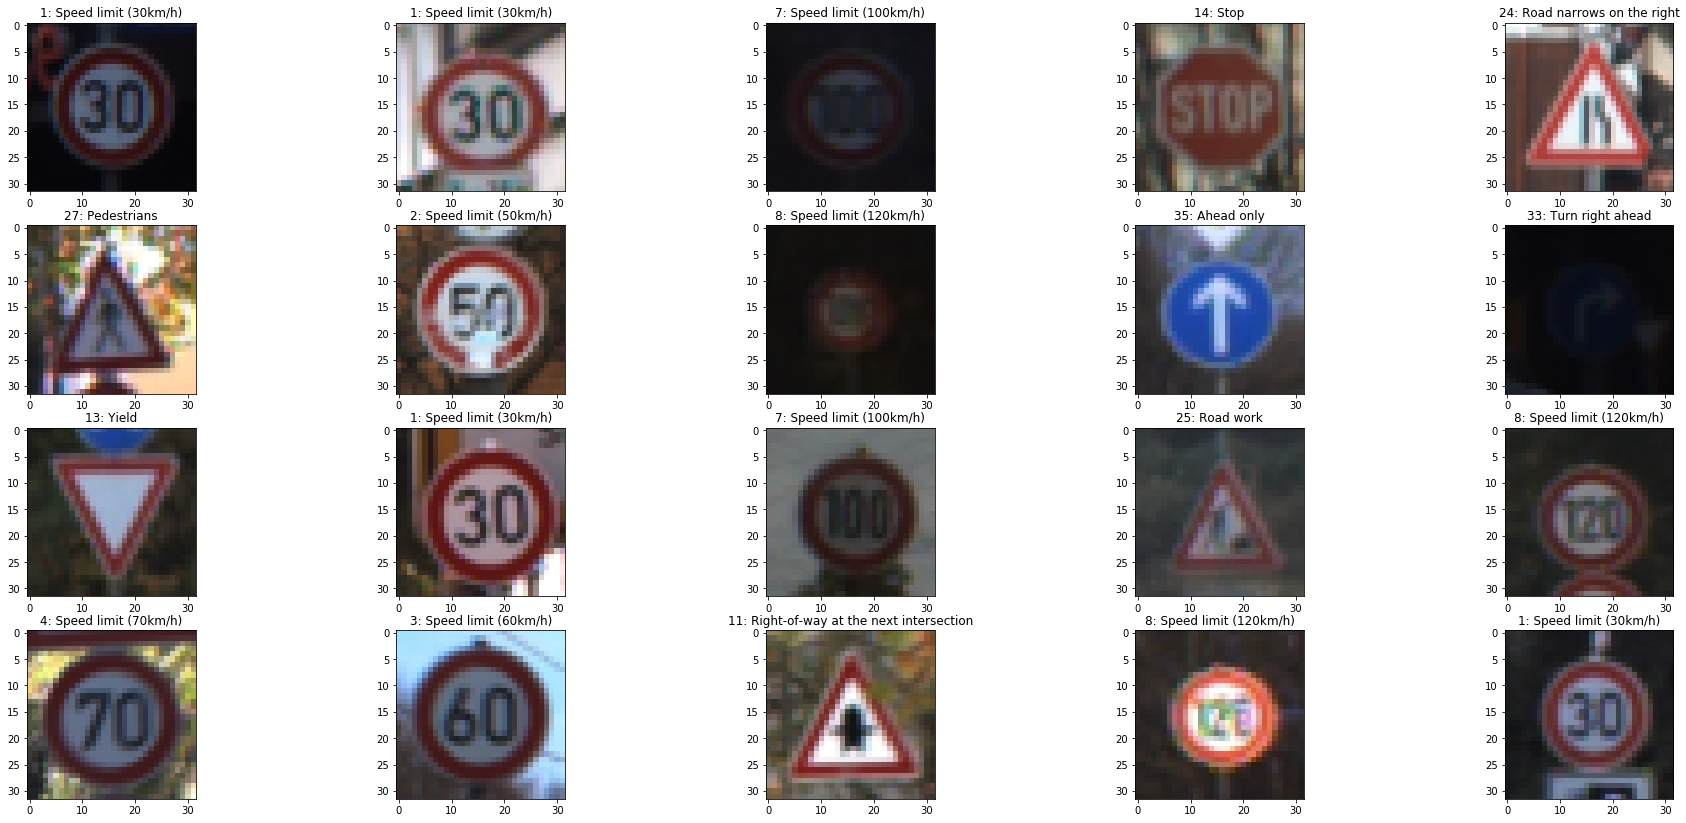

In [35]:
display_X_y_images(X_train, y_train, signnames_pd, start_idx=0, end_idx=20)

### Distribution of Training Images by Label

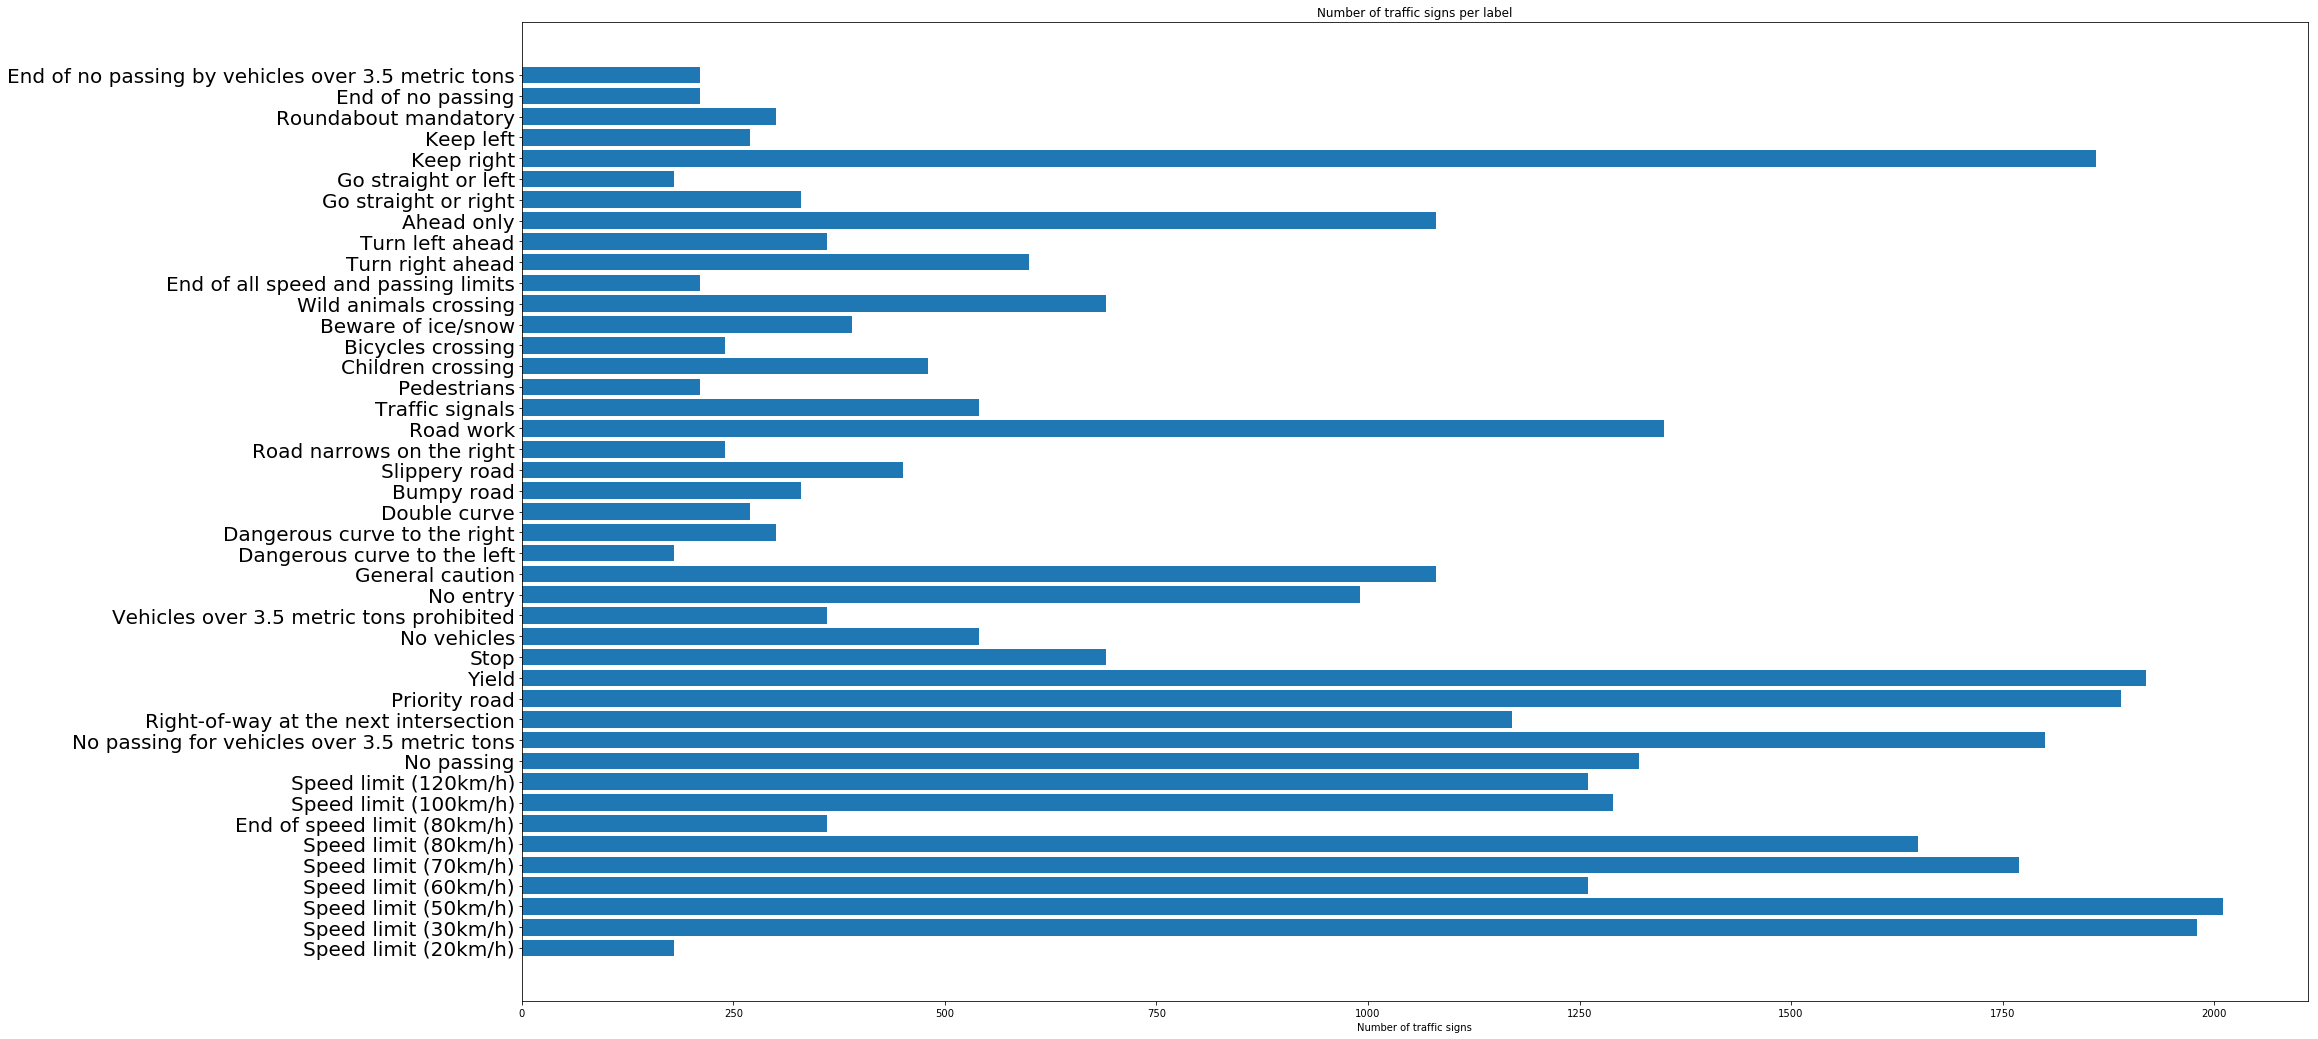

In [36]:
label_cnts = Counter(y_train)

x_vals = [x for x, _ in label_cnts.items()]
y_vals = [y for _, y in label_cnts.items()]    

plt.figure(figsize=(32,18))

plt.barh(x_vals, y_vals)
plt.title("Number of traffic signs per label")
plt.yticks(x_vals, [signname_val_to_name(signnames_pd, val) for val in x_vals], fontsize = 20)
plt.xlabel('Number of traffic signs')
#plt.ylabel('Label')
plt.show()

In [37]:
label_cnt_arr = label_cnts.most_common(43)
least_common_label, least_common_cnt = label_cnt_arr[-1]
least_common_label_name = signname_val_to_name(signnames_pd, least_common_label)

most_common_label, most_common_cnt = label_cnt_arr[0]
most_common_label_name = signname_val_to_name(signnames_pd, most_common_label)

print("Label with least number of examples: (%d)%s - %d" % (least_common_label, least_common_label_name, 
                                                            least_common_cnt))
print("Label with most number of examples: (%d)%s - %d" % (most_common_label, most_common_label_name, 
                                                            most_common_cnt))

Label with least number of examples: (37)Go straight or left - 180
Label with most number of examples: (2)Speed limit (50km/h) - 2010


In [38]:
def get_rgb_frequency(image, apply_fnc=None):
    temp_image = image.copy()
    if apply_fnc is not None:
        temp_image = apply_fnc(temp_image)
     
    num_of_pixels = np.prod(temp_image.shape)
    r_cnts = Counter(temp_image[:,:,0].reshape((-1)))
    g_cnts = Counter(temp_image[:,:,1].reshape((-1)))
    b_cnts = Counter(temp_image[:,:,2].reshape((-1)))

    rgb_cnts = [r_cnts, g_cnts, b_cnts]   
    
    y_vals_arr = []
    for i, color_cnt in enumerate(rgb_cnts):
        y_vals = np.array([color_cnt[i]/num_of_pixels for i in range(255)])
        y_vals_arr.append(y_vals)
        
    return np.stack(y_vals_arr, axis=1)

In [39]:
def rgb_hist(X, title, height=4, apply_fnc=None):
    temp_X = X.copy()
    if apply_fnc is not None:
        temp_X = apply_to_layers(temp_X, apply_fnc)
     
    num_of_pixels = np.prod(temp_X.shape)
    r_cnts = Counter(temp_X[:,:,0].reshape((-1)))
    g_cnts = Counter(temp_X[:,:,1].reshape((-1)))
    b_cnts = Counter(temp_X[:,:,2].reshape((-1)))

    rgb_cnts = [r_cnts, g_cnts, b_cnts]

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(16,height))
    axs = [ax1, ax2, ax3]
    titles = ['Red', 'Green', 'Blue']
    
    x_vals = [i for i in range(256)]

    for i, color_cnt in enumerate(rgb_cnts):
        ax = axs[i]

        y_vals = [color_cnt[i]/num_of_pixels for i in range(256)]
    
        ax.bar(x_vals, y_vals)
        ax.set_title(titles[i])
        ax.set_ylabel('Average Frequency per Image')
        ax.set_xlabel('Color value')
    
    plt.suptitle(title)
    
    plt.show() 

In [41]:
#rgb_hist(X_train, 'Average Color Frequencies per Image', height=4, apply_fnc=apply_histogram_equalization)

In [43]:
"""
label_image_dict = make_label_image_dict(X_train, y_train)
for i in range(43):
    curr_X_train = filter_images_by_label(i, label_image_dict=label_image_dict)
    label_name = signname_val_to_name(signnames_pd, i)
    rgb_hist(curr_X_train, 'Average Color Frequencies per Image: %s' % label_name, height=4, 
             apply_fnc=apply_histogram_equalization)
"""

"\nlabel_image_dict = make_label_image_dict(X_train, y_train)\nfor i in range(43):\n    curr_X_train = filter_images_by_label(i, label_image_dict=label_image_dict)\n    label_name = signname_val_to_name(signnames_pd, i)\n    rgb_hist(curr_X_train, 'Average Color Frequencies per Image: %s' % label_name, height=4, \n             apply_fnc=apply_histogram_equalization)\n"

#### t-sne Graph of RGB Histograms

In [44]:
"""
X_train_rgb_hist_arr = []
for i in tqdm(range(int(X_train.shape[0]*0.5))):
        X_train_rgb_hist_arr.append(get_rgb_frequency(X_train[i]))
    
X_train_rgb_hist = np.stack(X_train_rgb_hist_arr)  
y_train_rgb_hist = y_train.copy()

#X_train_rgb_hist = np.stack([get_rgb_frequency(X_train[i]) for i in range(X_train.shape[0])])
assert X_train_rgb_hist.shape[0] == int(X_train.shape[0]*0.5)
"""

'\nX_train_rgb_hist_arr = []\nfor i in tqdm(range(int(X_train.shape[0]*0.5))):\n        X_train_rgb_hist_arr.append(get_rgb_frequency(X_train[i], apply_fnc=apply_histogram_equalization))\n    \nX_train_rgb_hist = np.stack(X_train_rgb_hist_arr)  \ny_train_rgb_hist = y_train.copy()\n\n#X_train_rgb_hist = np.stack([get_rgb_frequency(X_train[i], apply_fnc=apply_histogram_equalization) for i in range(X_train.shape[0])])\nassert X_train_rgb_hist.shape[0] == int(X_train.shape[0]*0.5)\n'

In [45]:
"""
from sklearn.manifold import TSNE

X_train_rgb_hist_tsne = TSNE(n_components=2).fit_transform(X_train_rgb_hist.reshape((X_train_rgb_hist.shape[0], -1)))
"""

'\nfrom sklearn.manifold import TSNE\n\nX_train_rgb_hist_tsne = TSNE(n_components=2).fit_transform(X_train_rgb_hist.reshape((X_train_rgb_hist.shape[0], -1)))\n'

In [46]:
"""
x = X_train_rgb_hist_tsne[:,0]
y = X_train_rgb_hist_tsne[:,1]
c = y_train_rgb_hist[:X_train_rgb_hist_tsne.shape[0]]
"""

'\nx = X_train_rgb_hist_tsne[:,0]\ny = X_train_rgb_hist_tsne[:,1]\nc = y_train_rgb_hist[:X_train_rgb_hist_tsne.shape[0]]\n'

In [47]:
"""
plt.figure(figsize=(32,18))
plt.scatter(x, y, c=c, alpha=0.5)
plt.show()
"""

'\nplt.figure(figsize=(32,18))\nplt.scatter(x, y, c=c, alpha=0.5)\nplt.show()\n'

In [48]:
"""
for j in range(43):
    x = []
    y = []
    c = []

    for i in range(X_train_rgb_hist_tsne.shape[0]):
        if y_train[i] == j:
            x.append(X_train_rgb_hist_tsne[i, 0])
            y.append(X_train_rgb_hist_tsne[i,1])
            c.append(y_train[i])
            
    label_name = signname_val_to_name(signnames_pd, j)
    plt.figure(figsize=(32,18))
    plt.title('%d: %s' % (j, label_name))

    plt.scatter(x, y, c=c, alpha=0.5)
    plt.show()
"""

"\nfor j in range(43):\n    x = []\n    y = []\n    c = []\n\n    for i in range(X_train_rgb_hist_tsne.shape[0]):\n        if y_train[i] == j:\n            x.append(X_train_rgb_hist_tsne[i, 0])\n            y.append(X_train_rgb_hist_tsne[i,1])\n            c.append(y_train[i])\n            \n    label_name = signname_val_to_name(signnames_pd, j)\n    plt.figure(figsize=(32,18))\n    plt.title('%d: %s' % (j, label_name))\n\n    plt.scatter(x, y, c=c, alpha=0.5)\n    plt.show()\n"

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [49]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

In [50]:
def normalize_brightness(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV).astype(np.float32)
    
    mean_v = hsv[:, :, 2].mean()
    
    if mean_v == 0.0:
        return image
    
    ratio = 128.0/mean_v
    
    hsv[:, :, 2] = (hsv[:, :, 2] * ratio)
    
    v = hsv[:,:,2]
    v[v > 255.0] = 255.0
    hsv = hsv.astype(np.uint8)
    
    assert hsv[:, :, 2].max() <= 255
    
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB).astype(np.uint8)

In [51]:
def get_mask(hsv_img, lower_threshold, upper_threshold):
    if lower_threshold[0] <= upper_threshold[0]:
        return cv2.inRange(hsv_img, lower_threshold, upper_threshold)
    
    # deal with the looping red values
    _lower_threshold = np.array([0, lower_threshold[1], 
                                 lower_threshold[2]])
    _upper_threshold = np.array(upper_threshold)
    mask1 = cv2.inRange(hsv_img, _lower_threshold, _upper_threshold)
    mask1 = (mask1 == 255)

    _lower_threshold = np.array(lower_threshold)
    _upper_threshold = np.array([179, upper_threshold[1], 
                                 upper_threshold[2]])
    mask2 = cv2.inRange(hsv_img, _lower_threshold, _upper_threshold)
    mask2 = (mask2 == 255)

    mask = (255 * (mask1 | mask2)).astype(np.uint8)
    
    return mask

In [52]:
def get_red_mask(hsv_img):
    LIGHT_RED = np.array([160,20,25])
    DARK_RED = np.array([10,255,255])
    
    return get_mask(hsv_img, LIGHT_RED, DARK_RED)

In [53]:
from skimage import color

def get_black_mask(img):
    temp_img = img.copy().astype(np.uint8)
    #print("###get_black_mask", temp_img.min(), temp_img.max())
    
    gray_img = color.rgb2gray(temp_img).astype(np.float32)
    assert gray_img.min() >= 0.0 and gray_img.max() <= 255.0
    return (255.0 * gray_img).astype(np.uint8) 

In [54]:
def get_blue_mask(hsv_img):
    LIGHT_BLUE = np.array([110,25,25])
    DARK_BLUE = np.array([130,255,255])
    
    return get_mask(hsv_img, LIGHT_BLUE, DARK_BLUE)    

In [55]:
def get_yellow_mask(hsv_img):
    LIGHT_YELLOW = np.array([10, 25, 25])
    DARK_YELLOW = np.array([40,255,255])
    
    return get_mask(hsv_img, LIGHT_YELLOW, DARK_YELLOW)  

In [56]:
def get_color_mask(image):
    #eq_image = apply_histogram_equalization(image)
    #hsv = cv2.cvtColor(eq_image, cv2.COLOR_RGB2HSV).astype(np.float32) 
    #yuv = cv2.cvtColor(eq_image, cv2.COLOR_RGB2YUV).astype(np.float32) 
    
    mask_arr = [image[:,:,i] for i in range(image.shape[2])]
    #mask_arr += [hsv[:,:,i] for i in range(hsv.shape[2])]
    #mask_arr += [yuv[:,:,i] for i in range(yuv.shape[2])]
    
    #mask_arr.append(get_black_mask(image))
    #mask_arr.append(get_canny(eq_image, min_threshold=0, max_threshold=100))
    
    mask_arr.append(apply_histogram_equalization(image))
    
    color_mask = np.stack(mask_arr, axis=2)
    
    assert color_mask.shape[2] == 4, color_mask.shape
    
    return color_mask

In [57]:
from skimage import color

def get_canny(image, min_threshold=100, max_threshold=200):
    gray = (255.0 * color.rgb2gray(image)).astype(np.uint8)
    
    return cv2.Canny(gray, min_threshold, max_threshold)

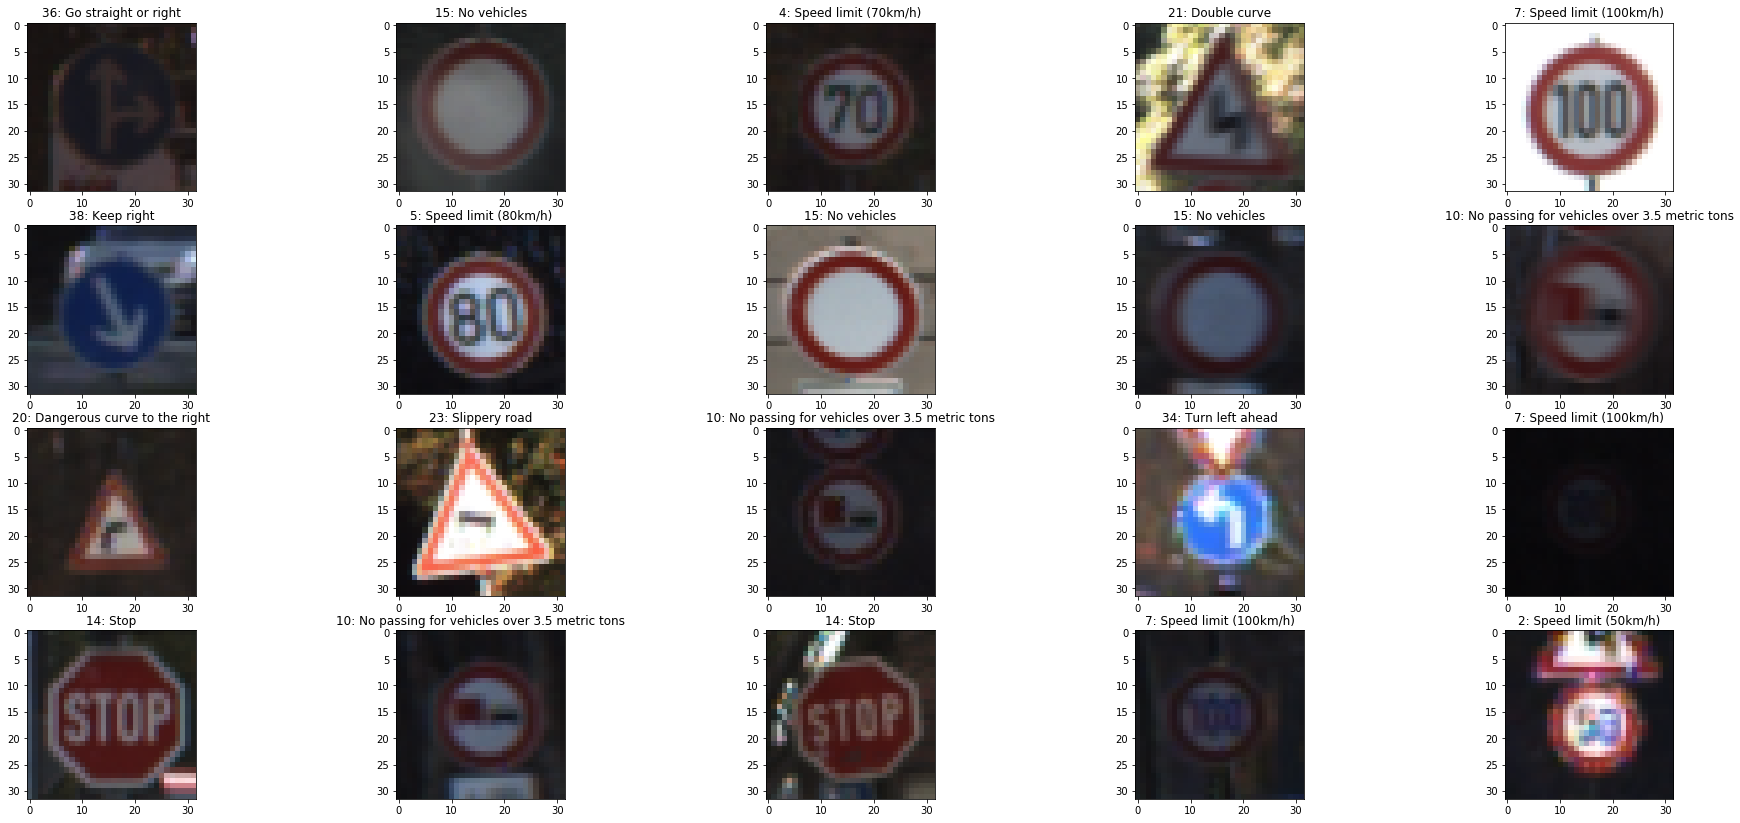

In [58]:
display_X_y_images(X_train, y_train, signnames_pd, 20, 40)

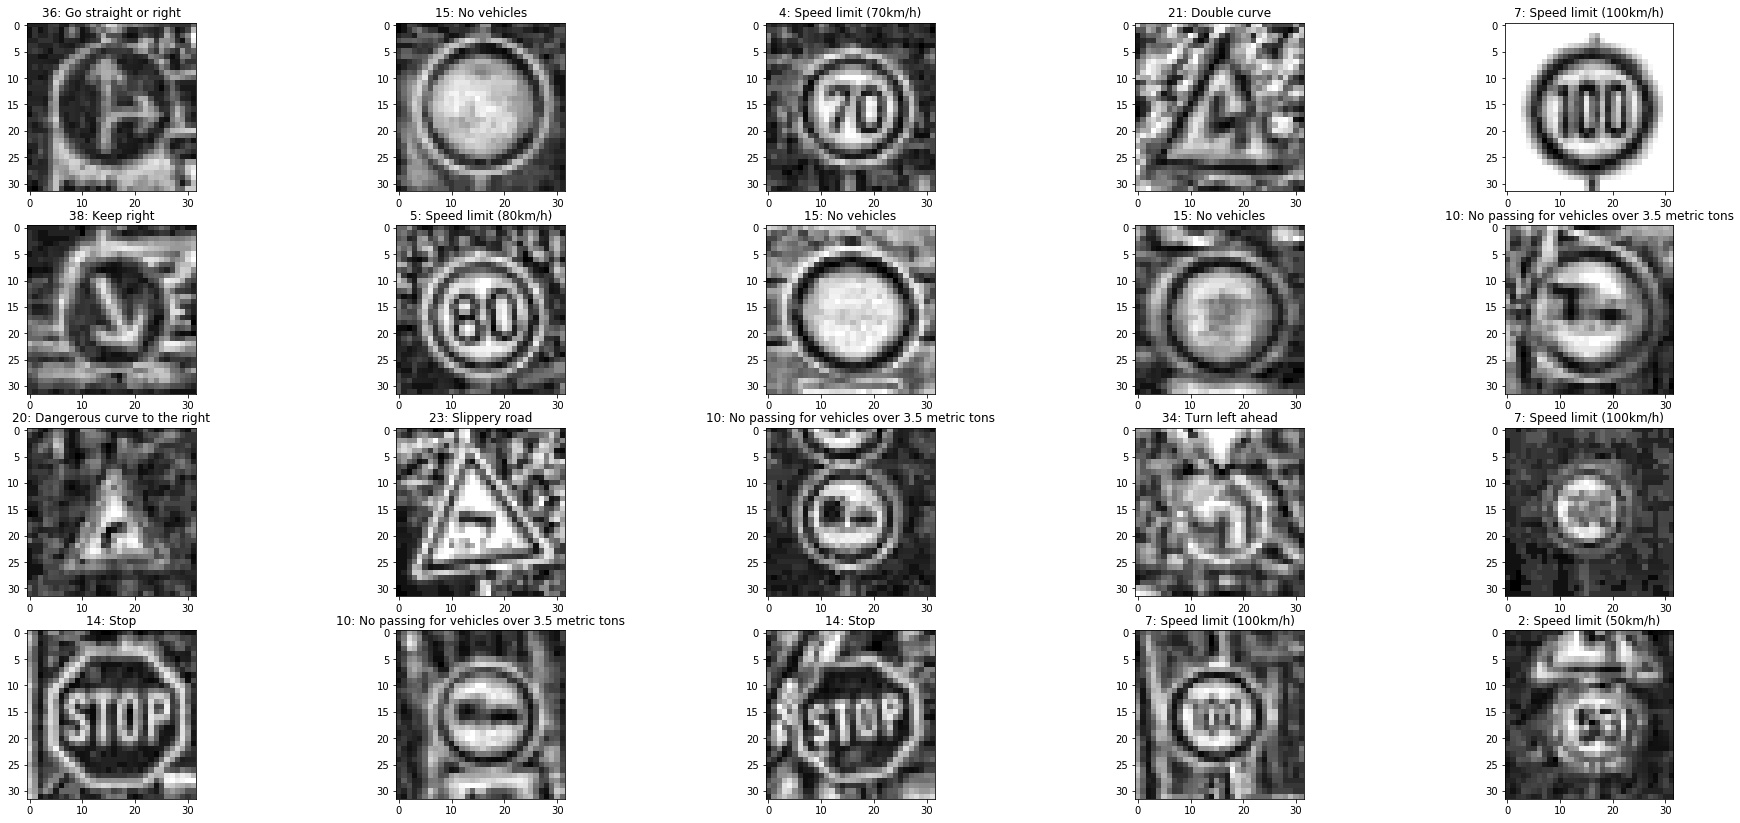

In [59]:
display_X_y_images(X_train, y_train, signnames_pd, 20, 40, use_gray=True, 
                   apply_fnc=apply_histogram_equalization)

# Augment data

For the training data, the numbers of images per label are not even.  Augment the data by doing on of the following transformations:
1. Rotate
    a. Rotation image from -45.0 to 45.0 degrees.
2. Gaussian Noise
    a. Add random Gaussian noise to image from -5.0 to 5.0.
    b. Truncate image values from 0.0 to 255.0.
3. Lighting
    a. Convert to hsv.
    b. Adjust light (v) value to 0.75 to 1.0.
    c. Convert back to rgb.

In [60]:
from skimage.transform import rotate, AffineTransform, warp
from random import uniform, randrange
import cv2

def apply_random_rotate(image, min_angle, max_angle):
    random_angle = uniform(min_angle, max_angle)
    
    return (255.0*rotate(image, random_angle)).astype(np.uint8)

def apply_random_shift(image, min_x_shift=-3, max_x_shift=3, min_y_shift=-3, max_y_shift=3):
    x_shift = randrange(min_x_shift, max_x_shift)
    y_shift = randrange(min_y_shift, max_y_shift)
    
    cols,rows = image.shape[0], image.shape[1]
    
    M = np.float32([[1,0,x_shift],[0,1,y_shift]])
    return cv2.warpAffine(image,M,(cols,rows))

def apply_random_shear(image, min_shear=-0.2, max_shear=0.2):
    shear = uniform(min_shear, max_shear)
    
    # Create Afine transform
    afine_tf = AffineTransform(shear=shear)

    # Apply transform to image data
    return warp(image, inverse_map=afine_tf)

def add_gaussian_noise(image, noise_sigma):
    temp_image = image.copy().astype(np.float32)
    
    h = temp_image.shape[0]
    w = temp_image.shape[1]
    noise = np.random.randn(h, w) * noise_sigma
    
    noisy_image = np.zeros(temp_image.shape)
    
    noisy_image[:,:,0] = temp_image[:,:,0] + noise
    noisy_image[:,:,1] = temp_image[:,:,1] + noise
    noisy_image[:,:,2] = temp_image[:,:,2] + noise    
    
    noisy_image[noisy_image < 0.0] = 0.0
    noisy_image[noisy_image > 255.0] = 255.0
    
    return noisy_image.astype(np.uint8)

def apply_random_light(image, min_perc, max_perc):
    light_perc = uniform(min_perc, max_perc)
    
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv[:, :, 2] = hsv[:, :, 2] * light_perc
    
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

In [61]:
def balance_images(X, y, min_angle, max_angle, noise_sigma):
    """
    All labels will have the same number of images as the label with the max number of images.
    """
    label_cnts = Counter(y_train)
    
    max_cnt = max([y for _, y in label_cnts.items()])
    
    image_dict = make_label_image_dict(X, y)
    
    """
    image_dict = {}
    for i in range(X.shape[0]):
        curr_image = X[i]
        curr_y = y[i]
        
        if curr_y in image_dict:
            image_dict[curr_y].append(curr_image)
        else:
            image_dict[curr_y] = [curr_image]
    """
            
    for label, image_arr in image_dict.items():
        initial_cnt = len(image_arr)
        for i in range(max_cnt-initial_cnt):
            idx = randrange(0, initial_cnt)
            curr_image = image_arr[idx]
            
            rnd = randrange(0,3)
            if rnd == 0:
                alt_image = add_gaussian_noise(curr_image, noise_sigma)    
            elif rnd == 1: 
                alt_image = apply_random_rotate(curr_image, min_angle, max_angle)            
            else:
                alt_image = add_gaussian_noise(curr_image, noise_sigma) 
                alt_image = apply_random_rotate(alt_image, min_angle, max_angle)
                
            image_dict[label].append(alt_image)
            
    balanced_label_arr = []
    balanced_image_arr = []
    for label, image_arr in image_dict.items():
        balanced_label_arr += [label] * len(image_arr)
        balanced_image_arr += image_arr
        
    balanced_labels = np.array(balanced_label_arr).reshape((-1))
    balanced_images = np.stack(balanced_image_arr)
    
    return balanced_images, balanced_labels

In [62]:
def balance_images2(X, y, min_angle, max_angle, noise_sigma):
    """
    All labels will have the same number of images as the label with the min number of images.
    """    
    label_cnts = Counter(y_train)
    
    min_cnt = min([y for _, y in label_cnts.items()])
    
    image_dict = make_label_image_dict(X, y)
    
    balanced_label_arr = []
    balanced_image_arr = []
    for i in range(43):
        balanced_label_arr += [i] * min_cnt
        balanced_image_arr += image_dict[i][:min_cnt]
        
    balanced_labels = np.array(balanced_label_arr).reshape((-1))
    balanced_images = np.stack(balanced_image_arr)
    
    assert balanced_labels.shape[0] == balanced_images.shape[0]
    
    return balanced_images, balanced_labels

In [63]:
def multiply_images(X, y, min_angle, max_angle, noise_sigma, multiplier=2):
    """
    Multiply images to keep the same ratio of images.
    """
    assert multiplier > 1.0
    
    label_cnts = Counter(y_train)
    image_dict = make_label_image_dict(X, y)
            
    for label, image_arr in image_dict.items():
        initial_cnt = len(image_arr)
        for i in range(int((multiplier-1)*initial_cnt)):
            idx = randrange(0, initial_cnt)
            curr_image = image_arr[idx]
            
            rnd = randrange(0,3)
            if rnd == 0:
                alt_image = add_gaussian_noise(curr_image, noise_sigma)    
            elif rnd == 1: 
                alt_image = apply_random_rotate(curr_image, min_angle, max_angle)            
            else:
                alt_image = add_gaussian_noise(curr_image, noise_sigma) 
                alt_image = apply_random_rotate(alt_image, min_angle, max_angle)
                
            image_dict[label].append(alt_image)
            
    balanced_label_arr = []
    balanced_image_arr = []
    for label, image_arr in image_dict.items():
        balanced_label_arr += [label] * len(image_arr)
        balanced_image_arr += image_arr
        
    balanced_labels = np.array(balanced_label_arr).reshape((-1))
    balanced_images = np.stack(balanced_image_arr)
    
    return balanced_images, balanced_labels

In [64]:
X_train_balanced, y_train_balanced = balance_images(X_train, y_train, -12.5, 12.5, 5)
#X_train_balanced, y_train_balanced = balance_images2(X_train, y_train, -12.5, 12.5, 5)
#X_train_balanced, y_train_balanced = multiply_images(X_train, y_train, -12.5, 
#                                                     12.5, 5, multiplier=2)
idxs = [x for x in range(X_train_balanced.shape[0])]
shuffle(idxs)
X_train_balanced = X_train_balanced[idxs]
y_train_balanced = y_train_balanced[idxs]

In [68]:
X_train_balanced.shape

(86430, 32, 32, 3)

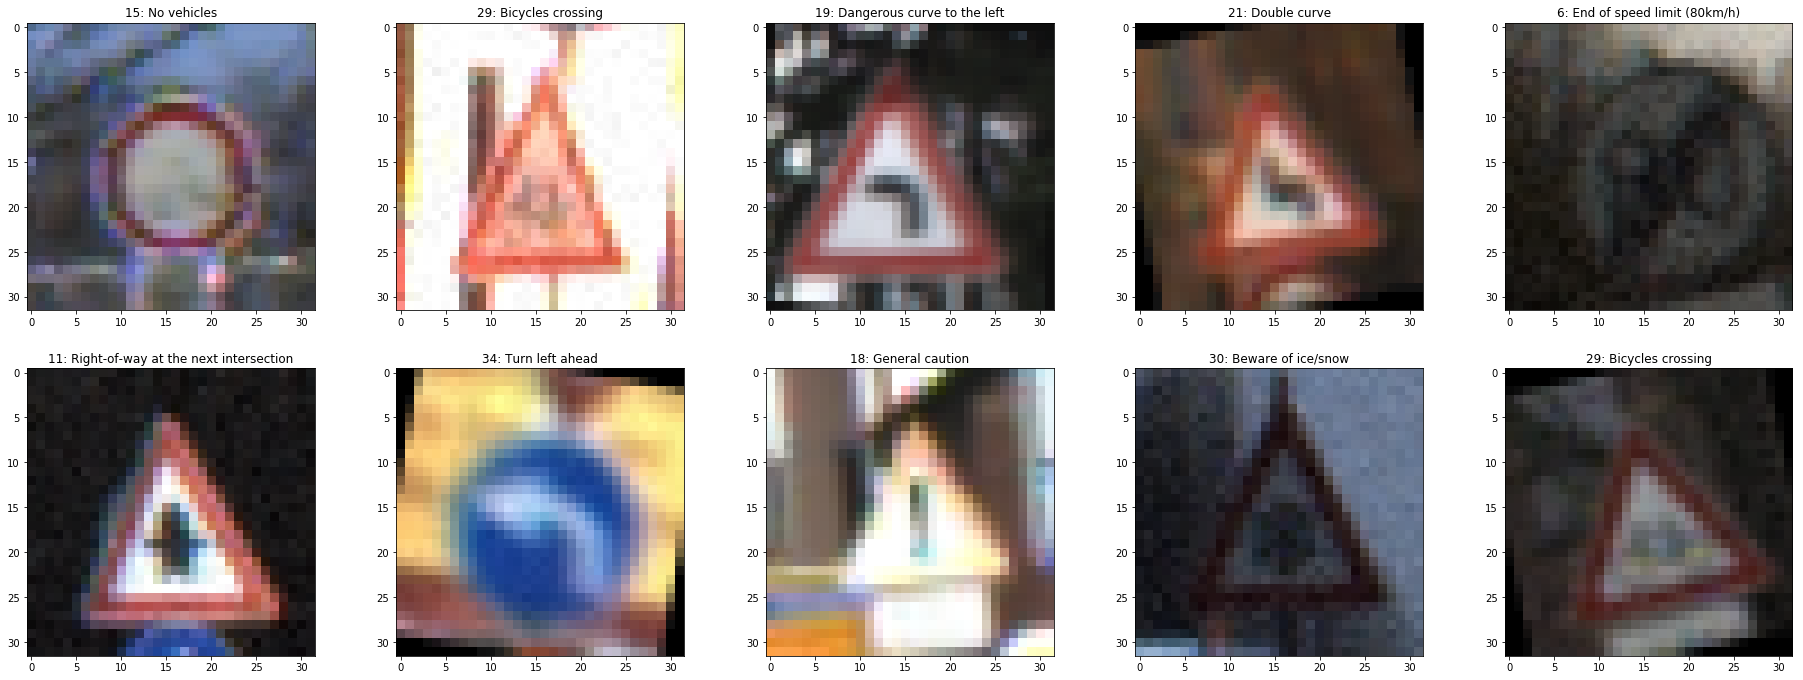

In [69]:
display_X_y_images(X_train_balanced, y_train_balanced, signnames_pd, 10, 20)

In [70]:
def preprocess_images(images):
    temp_images = images.copy().astype(np.float32)
    
    masked_images = np.stack([get_color_mask(temp_images[i]) for i in 
                              tqdm(range(temp_images.shape[0]))]).astype(np.float32)
    
    """
    masked_images = None
    for i in tqdm(range(temp_images.shape[0])):
        masked_image = get_color_mask(temp_images[i])
        if masked_images is None:
            masked_images = np.array([masked_image])
        else:
            masked_images = np.append(masked_images, masked_image)
    """    
    assert masked_images.shape[0] == temp_images.shape[0], (masked_images.shape[0],
                                                            temp_images.shape[0])
    
    """
    for i in range(temp_images.shape[3]):
        min_val = temp_images[:, :, :, i].min()
        max_val = temp_images[:, :, :, i].max()
    
        val_range = max_val - min_val
        
        if val_range > 0:
            temp_images[:, :, :, i] = (temp_images[:, :, :, i]/float(val_range)) - 0.5
    """
    
    """
    # standardize data
    for i in range(masked_images.shape[3]):
        curr_layer = masked_images[:, :, :, i]
        mean_val = curr_layer.mean()
        
        std_val = np.std(curr_layer) + 1.0**-9

        masked_images[:, :, :, i] = (masked_images[:, :, :, i] - mean_val)/std_val
    """
    
    # normalize data
    for i in tqdm(range(masked_images.shape[3])):
        curr_layer = masked_images[:, :, :, i]
        min_val = curr_layer.min()
        max_val = curr_layer.max()
        mean_val = curr_layer.mean()
            
        val_range = max_val - min_val + 1.0**-9
        
        #masked_images[:, :, :, i] = 0.5*(curr_layer-mean_val)/val_range    
        masked_images[:, :, :, i] = (curr_layer-mean_val)/val_range

    return masked_images

In [71]:
"""
sample_len = int(0.6*X_train_balanced.shape[0])
X_train_preprocessed = preprocess_images(X_train_balanced[0:sample_len])
y_train_preprocessed = y_train_balanced[0:sample_len]
"""
X_train_preprocessed = preprocess_images(X_train_balanced)
y_train_preprocessed = y_train_balanced

X_valid_preprocessed = preprocess_images(X_valid)
X_test_preprocessed = preprocess_images(X_test)

100%|██████████| 4/4 [00:00<00:00,  6.08it/s]


In [72]:
X_train_preprocessed.min(), X_train_preprocessed.max(), X_train_preprocessed.mean()

(-0.47757122, 0.68790972, -3.9817391e-07)

In [73]:
X_train_preprocessed.shape

(86430, 32, 32, 4)

In [74]:
for i in range(X_train_preprocessed.shape[3]):
    print(X_train_preprocessed[:,:,i].min(), 
          X_train_preprocessed[:,:,i].max(), 
          X_train_preprocessed[:,:,i].mean())

-0.477571 0.68791 -0.0584102
-0.477571 0.68791 -0.0274099
-0.477571 0.68791 -0.012686
-0.477571 0.68791 -0.00891662


### Model Architecture

In [75]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

In [78]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

In [79]:
def leaky_relu(x, alpha):
    return tf.maximum(alpha * x, x) 

def conv_layer(x, num_input_channels, num_output_channels, mu, sigma, window=(5,5)):
    window_x,window_y = window
    conv_W = tf.Variable(tf.truncated_normal(shape=(window_x, window_y, 
                                                    num_input_channels, num_output_channels), 
                                                     mean = mu, stddev = sigma))
    conv_b = tf.Variable(tf.zeros(num_output_channels))
    return tf.nn.conv2d(x, conv_W, strides=[1, 1, 1, 1], padding='SAME') + conv_b, conv_W

def fully_connected(x, shape_in, shape_out, mu = 0, sigma = 0.1):
    fc_W  = tf.Variable(tf.truncated_normal(shape=(shape_in, shape_out), 
                                            mean = mu, stddev = sigma))
    fc_b  = tf.Variable(tf.zeros(shape_out))
    return tf.matmul(x, fc_W) + fc_b, fc_W

In [109]:
"""
def model(x, channel_depth, mu = 0, sigma = 0.1, alpha=0.05): 
    # Layer 1: Convolutional. Input = 32x32x10. Output = 32x32x16.
    conv1, conv1_W = conv_layer(x, channel_depth, 16, mu, sigma)
    print(conv1.get_shape())

    # Leaky ReLU
    conv1 = leaky_relu(conv1, alpha)      

    # Pooling. Input = 32x32x16. Output = 16x16x16.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    print(conv1.get_shape())

    # Layer 2: Convolutional. Output = 16x16x32.
    conv2, conv2_W = conv_layer(conv1, 16, 32, mu, sigma)
    print(conv2.get_shape())

    # Leaky ReLU
    conv2 = leaky_relu(conv2, alpha)  

    # Pooling. Input = 16x16x32. Output = 8x8x32.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    print(conv2.get_shape())

    # Layer 3: Convolutional. Output = 8x8x64.
    conv3, conv3_W = conv_layer(conv2, 32, 64, mu, sigma)
    print(conv3.get_shape())

    # Leaky ReLU
    conv3 = leaky_relu(conv3, alpha)  

    # Pooling. Input = 8x8x64. Output = 4x4x64.
    conv3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME') 
    print(conv3.get_shape())

    # Flatten. Input = 4x4x64. Output = 1024.
    fc0   = flatten(conv3)

    # Layer 3: Fully Connected. Input = 1024. Output = 512.
    fc1, fc1_W = fully_connected(fc0, 1024, 512, mu, sigma)

    # Leaky ReLU
    fc1 = leaky_relu(fc1, alpha)  
    
    # dropout
    keep_prob = tf.placeholder(tf.float32)
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 512. Output = 256.
    fc2, fc2_W = fully_connected(fc1, 512, 256, mu, sigma)

    # Leaky ReLU
    fc2 = leaky_relu(fc2, alpha)   
    
    # dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)    

    # Layer 5: Fully Connected. Input = 256. Output = 43.
    logits, fc3_W = fully_connected(fc2, 256, 43, mu, sigma)

    return logits, keep_prob, [conv1_W, conv1a_W, conv2_W, conv3_W, fc1_W, fc2_W, fc3_W]
"""

In [121]:
def model(x, channel_depth, mu = 0, sigma = 0.1, alpha=0.05): 
    # Layer 1: Convolutional. Input = 32x32x10. Output = 32x32x16.
    conv1, conv1_W = conv_layer(x, channel_depth, 16, mu, sigma)
    print(conv1.get_shape())

    # Leaky ReLU
    conv1 = leaky_relu(conv1, alpha)      

    # Pooling. Input = 32x32x16. Output = 16x16x16.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    print(conv1.get_shape())

    # Layer 2: Convolutional. Output = 16x16x32.
    conv2, conv2_W = conv_layer(conv1, 16, 32, mu, sigma)
    print(conv2.get_shape())

    # Leaky ReLU
    conv2 = leaky_relu(conv2, alpha)  

    # Pooling. Input = 16x16x32. Output = 8x8x32.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    print(conv2.get_shape())

    # Layer 3: Convolutional. Output = 8x8x64.
    conv3, conv3_W = conv_layer(conv2, 32, 64, mu, sigma)
    print(conv3.get_shape())

    # Leaky ReLU
    conv3 = leaky_relu(conv3, alpha)  

    # Pooling. Input = 8x8x64. Output = 4x4x64.
    conv3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME') 
    print(conv3.get_shape())
    
    # Layer 4: Convolutional. Output = 4x4x128.
    conv4, conv4_W = conv_layer(conv3, 64, 128, mu, sigma)
    print(conv4.get_shape())

    # Leaky ReLU
    conv4 = leaky_relu(conv4, alpha)  

    # Pooling. Input = 4x4x128. Output = 2x2x128.
    conv4 = tf.nn.max_pool(conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME') 
    print(conv4.get_shape())    

    # Flatten. Input = 2x2x128. Output = 512.
    fc0   = flatten(conv4)

    print("###1")
    # Layer 3: Fully Connected. Input = 512. Output = 256.
    fc1, fc1_W = fully_connected(fc0, 512, 256, mu, sigma)
    print("###2")
    
    # Leaky ReLU
    fc1 = leaky_relu(fc1, alpha)  
    
    # dropout
    keep_prob = tf.placeholder(tf.float32)
    fc1 = tf.nn.dropout(fc1, keep_prob)

    print("###3")
    # Layer 4: Fully Connected. Input = 256. Output = 128.
    fc2, fc2_W = fully_connected(fc1, 256, 128, mu, sigma)
    print("###4")

    # Leaky ReLU
    fc2 = leaky_relu(fc2, alpha)   
    
    # dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)    
    
    print("###5")
    # Layer 5: Fully Connected. Input = 128. Output = 43.
    logits, fc3_W = fully_connected(fc2, 128, 43, mu, sigma)
    print("###6")

    return logits, keep_prob, [conv1_W, conv2_W, conv3_W, conv4_W, fc1_W, fc2_W, fc3_W]

In [122]:
channel_depth = 4
x = tf.placeholder(tf.float32, (None, 32, 32, channel_depth))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

In [130]:
#rate = 0.001
rate = 0.0001
#alpha = 0.000001
alpha = 0.00001
beta = 0.0001

logits, keep_prob, weights = model(x, channel_depth, alpha=alpha)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)

loss_operation = tf.reduce_mean(cross_entropy)


# Loss function using L2 Regularization
regularizer = None
for weight in weights:
    if regularizer is None:
        regularizer = tf.nn.l2_loss(weight)
    else:
        regularizer = regularizer + tf.nn.l2_loss(weight)
loss_operation = tf.reduce_mean(loss_operation + beta * regularizer)

optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

(?, 32, 32, 16)
(?, 16, 16, 16)
(?, 16, 16, 32)
(?, 8, 8, 32)
(?, 8, 8, 64)
(?, 4, 4, 64)
(?, 4, 4, 128)
(?, 2, 2, 128)
###1
###2
###3
###4
###5
###6


### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [131]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

In [137]:
EPOCHS = 200
BATCH_SIZE = 128

In [138]:
logits_argmax = tf.argmax(logits, 1, name='logits_argmax')
one_hot_y_argmax = tf.argmax(one_hot_y, 1, name='one_hot_y_argmax')
correct_prediction = tf.equal(logits_argmax, one_hot_y_argmax, name='correct_prediction')
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [139]:
keep_prob_val = 0.5

best_validation_accuracy_epoch = 0
best_validation_accuracy = 0.0

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_preprocessed)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_preprocessed, y_train_preprocessed = shuffle_X_y(X_train_preprocessed, y_train_preprocessed)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_preprocessed[offset:end], y_train_preprocessed[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: keep_prob_val})
        
        validation_accuracy = evaluate(X_valid_preprocessed, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        
        if best_validation_accuracy < validation_accuracy:
            best_validation_accuracy = validation_accuracy
            best_validation_accuracy_epoch = i+1
            saver.save(sess, './lenet')
            print("Model saved")
            
        print()
            
    print("Best model - epoch: %d, best validation accuracy: %.2f" % (best_validation_accuracy_epoch,
                                                                     best_validation_accuracy))

Training...

EPOCH 1 ...
Validation Accuracy = 0.179
Model saved

EPOCH 2 ...
Validation Accuracy = 0.435
Model saved

EPOCH 3 ...
Validation Accuracy = 0.602
Model saved

EPOCH 4 ...
Validation Accuracy = 0.668
Model saved

EPOCH 5 ...
Validation Accuracy = 0.730
Model saved

EPOCH 6 ...
Validation Accuracy = 0.785
Model saved

EPOCH 7 ...
Validation Accuracy = 0.792
Model saved

EPOCH 8 ...
Validation Accuracy = 0.829
Model saved

EPOCH 9 ...
Validation Accuracy = 0.856
Model saved

EPOCH 10 ...
Validation Accuracy = 0.867
Model saved

EPOCH 11 ...
Validation Accuracy = 0.866

EPOCH 12 ...
Validation Accuracy = 0.890
Model saved

EPOCH 13 ...
Validation Accuracy = 0.892
Model saved

EPOCH 14 ...
Validation Accuracy = 0.901
Model saved

EPOCH 15 ...
Validation Accuracy = 0.900

EPOCH 16 ...
Validation Accuracy = 0.899

EPOCH 17 ...
Validation Accuracy = 0.912
Model saved

EPOCH 18 ...
Validation Accuracy = 0.909

EPOCH 19 ...
Validation Accuracy = 0.915
Model saved

EPOCH 20 ...
Valid

In [140]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test_preprocessed, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.956


#### Histogram model

In [ ]:
def hist_model(x, mu = 0, sigma = 0.1, alpha=0.05):
    # fully connected 1
    fc1, fc1_W = fully_connected(x, 3072, 1536, mu = 0, sigma = 0.1)
    
    # Leaky ReLU
    fc1 = leaky_relu(fc1, alpha)  
    
    # dropout
    keep_prob = tf.placeholder(tf.float32)
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    # fully connected 2
    fc2, fc2_W  = fully_connected(fc1, 1536, 768, mu = 0, sigma = 0.1)
    
    # Leaky ReLU
    fc2 = leaky_relu(fc2, alpha)  
    
    # dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)    
    
    logits, fc3_W = fully_connected(fc2, 256, 43, mu, sigma)
    
    return logits, keep_prob, [fc1_W, fc2_W, fc3_W]

In [ ]:
x = tf.placeholder(tf.float32, (None, 3072))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

In [ ]:
rate = 0.001
alpha = 0.00001
beta = 0.0001

logits, keep_prob, weights = hist_model(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)

loss_operation = tf.reduce_mean(cross_entropy)


# Loss function using L2 Regularization
regularizer = None
for weight in weights:
    if regularizer is None:
        regularizer = tf.nn.l2_loss(weight)
    else:
        regularizer = regularizer + tf.nn.l2_loss(weight)
loss_operation = tf.reduce_mean(loss_operation + beta * regularizer)

optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [ ]:
EPOCHS = 100
BATCH_SIZE = 128

In [ ]:
logits_argmax = tf.argmax(logits, 1, name='logits_argmax')
one_hot_y_argmax = tf.argmax(one_hot_y, 1, name='one_hot_y_argmax')
correct_prediction = tf.equal(logits_argmax, one_hot_y_argmax, name='correct_prediction')
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [ ]:
keep_prob_val = 0.5

best_validation_accuracy_epoch = 0
best_validation_accuracy = 0.0

model_path = '%s/hist_model' % data_dir
if not os.path.exists(model_path):
    os.mkdir(model_path)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_preprocessed)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_preprocessed, y_train_preprocessed = shuffle_X_y(X_train_preprocessed, y_train_preprocessed)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_preprocessed[offset:end], y_train_preprocessed[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: keep_prob_val})
        
        validation_accuracy = evaluate(X_valid_preprocessed, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        
        if best_validation_accuracy < validation_accuracy:
            best_validation_accuracy = validation_accuracy
            best_validation_accuracy_epoch = i+1
            saver.save(sess, model_path)
            print("Model saved")
            
        print()
            
    print("Best model - epoch: %d, best validation accuracy: %.2f" % (best_validation_accuracy_epoch,
                                                                     best_validation_accuracy))

In [ ]:
def display_layers(image):
    plt.figure(figsize=(32,18))

    for i in range(image.shape[2]):
        layer = image[:,:,i]
        
        plt.subplot(1, image.shape[2], i + 1)
        
        plt.imshow(layer, cmap='gray')    
    
    plt.show()

In [ ]:
X_val_preprocessed = preprocess_images(X_valid)
y_val_preprocessed = y_valid

top_logits = tf.nn.top_k(tf.nn.softmax(logits), k=5, name='top_logits')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    logits_result = sess.run(logits_argmax, feed_dict={x: X_val_preprocessed, keep_prob: 1.0})

bad_labels = []
for i in range(logits_result.shape[0]):
    if y_val_preprocessed[i] != logits_result[i]:
        bad_labels.append(y_val_preprocessed[i])
        
bad_label_cnt_dict = Counter(bad_labels)

for label, count in bad_label_cnt_dict.most_common(10):
    print(label, signname_val_to_name(signnames_pd, label), count)

In [ ]:
X_val_preprocessed = preprocess_images(X_valid)
y_val_preprocessed = y_valid

#X_val_preprocessed, y_val_preprocessed = shuffle_X_y(X_val_preprocessed, y_val_preprocessed)
start_idx = 0
end_idx = 300

top_logits = tf.nn.top_k(tf.nn.softmax(logits), k=5, name='top_logits')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    top_logits_result = sess.run(top_logits, 
                                 feed_dict={x: X_val_preprocessed[start_idx:end_idx], 
                                            keep_prob: 1.0})

logit_vals, label_vals = top_logits_result     
for i, idx in enumerate(range(start_idx, end_idx)): 
    curr_logit_vals = logit_vals[i]
    curr_label_vals = label_vals[i]
    
    if y_val_preprocessed[idx] != curr_label_vals[0]:
        bad_image = X_valid[idx]
        plt.imshow(X_valid[idx])
        plt.show()
        #plt.imshow(apply_histogram_equalization(X_valid[idx]))
        #plt.imshow(get_canny(X_valid[idx], min_threshold=120, max_threshold=200), cmap="gray")
        plt.imshow(get_black_mask(X_valid[idx]), cmap="gray")
        display_layers(X_valid_preprocessed[idx])
        print("%d: %d - %s" % (idx, y_val_preprocessed[idx], signname_val_to_name(signnames_pd, y_val_preprocessed[idx])))

        for j in range(curr_logit_vals.shape[0]):
            print("\t%.4f\t%s" % (curr_logit_vals[j], signname_val_to_name(signnames_pd, curr_label_vals[j])))
              
        print()

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

In [94]:
def read_images(img_dir, csv_file, csv_delimiter=';'):
    meta_pd = pd.read_csv('%s/%s' % (img_dir, csv_file), delimiter=csv_delimiter)
    
    image_arr = []
    
    for index, row in meta_pd.iterrows():
        filename = '%s/%s' % (img_dir, row['Filename'])
        
        pil_image = Image.open(filename)
        image = np.array(pil_image)
        image_arr.append(image)
        
    return image_arr, meta_pd

In [95]:
def crop_resize_images(image_arr, meta_pd, resize_dim):
    cropped_resized_images = []
    
    for index, row in meta_pd.iterrows():
        image = image_arr[index]
        assert image.shape[0] == row['Height'], "image.shape[0] = %d, row['Height'] = %d" % (image.shape[0], row['Height'])
        assert image.shape[1] == row['Width'], "image.shape[1] = %d, row['Width'] = %d" % (image.shape[1], row['Width'])
        
        cropped_image = image[row['Roi.Y1']:row['Roi.Y2'], row['Roi.X1']:row['Roi.X2']]   
        resized_image = resize(cropped_image, resize_dim, mode='constant')
        
        cropped_resized_images.append(resized_image)
        
    return np.stack(cropped_resized_images)

In [96]:
def make_image_dataset(main_img_dir, resize_dim=(32, 32, 3), csv_delimiter=';', has_subdirs=True):
    feature_arr = []
    label_arr = []
    sizes = []
    coords = []
    
    if has_subdirs:
        for curr_dir in tqdm([x for x in os.listdir(main_img_dir) if not x.startswith('.') and x != 'annotations']):
            csv_file = [x for x in os.listdir('%s/%s' % (main_img_dir, curr_dir)) if x.endswith('.csv')][0]
            image_arr, meta_pd = read_images('%s/%s' % (main_img_dir, curr_dir), csv_file, csv_delimiter=csv_delimiter)
                                          
            cr_images = crop_resize_images(image_arr, meta_pd, resize_dim)
            feature_arr.append(cr_images)
        
            label_arr += [int(curr_dir)] * cr_images.shape[0]
            sizes += [(row['Width'], row['Height']) for _, row in meta_pd.iterrows()]
            coords += [(row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2']) for _, row in meta_pd.iterrows()]
    else:
        csv_file = [x for x in os.listdir(main_img_dir) if x.endswith('.csv')][0]
        image_arr, meta_pd = read_images(main_img_dir, csv_file, csv_delimiter=csv_delimiter)
                                          
        cr_images = crop_resize_images(image_arr, meta_pd, resize_dim)
        feature_arr.append(cr_images)
        
        # since it's not in a subdir, set it to an unknown label
        label_arr += meta_pd['ClassId'].tolist()
        sizes += [(row['Width'], row['Height']) for _, row in meta_pd.iterrows()]
        coords += [(row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2']) for _, row in meta_pd.iterrows()]        
          
    features = (255.0 * np.concatenate(feature_arr, axis=0)).astype(np.uint8)
    labels = np.array(label_arr)
    
    assert features.shape[0] == labels.shape[0]
    assert labels.shape[0] == len(sizes)
    assert len(sizes) == len(coords)
    
    return {
        'features': features,
        'labels': labels,
        'sizes': sizes,
        'coords': coords
    }                                                              
        

In [108]:
extra_images_dir = 'extra'
extra_image_dataset = make_image_dataset(extra_images_dir, resize_dim=(32, 32, 3), csv_delimiter="\t", has_subdirs=False)

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/PIL/Image.py:678: ResourceWarning: unclosed file <_io.BufferedReader name='extra/459381023.jpg'>
  self.load()
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/PIL/Image.py:678: ResourceWarning: unclosed file <_io.BufferedReader name='extra/459381075.jpg'>
  self.load()
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/PIL/Image.py:678: ResourceWarning: unclosed file <_io.BufferedReader name='extra/459381295.jpg'>
  self.load()
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/PIL/Image.py:678: ResourceWarning: unclosed file <_io.BufferedReader name='extra/469763323.jpg'>
  self.load()
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/PIL/Image.py:678: ResourceWarning: unclosed file <_io.BufferedReader name='extra/a-blue-circular-ahead-only-directional-road-sign-or-traffic-sign-with-A7F488.jpg'>
  self.load()
/home/carnd/anaconda3/envs/carnd-term1/lib/

In [98]:
X_extra, y_extra = extra_image_dataset['features'], extra_image_dataset['labels']

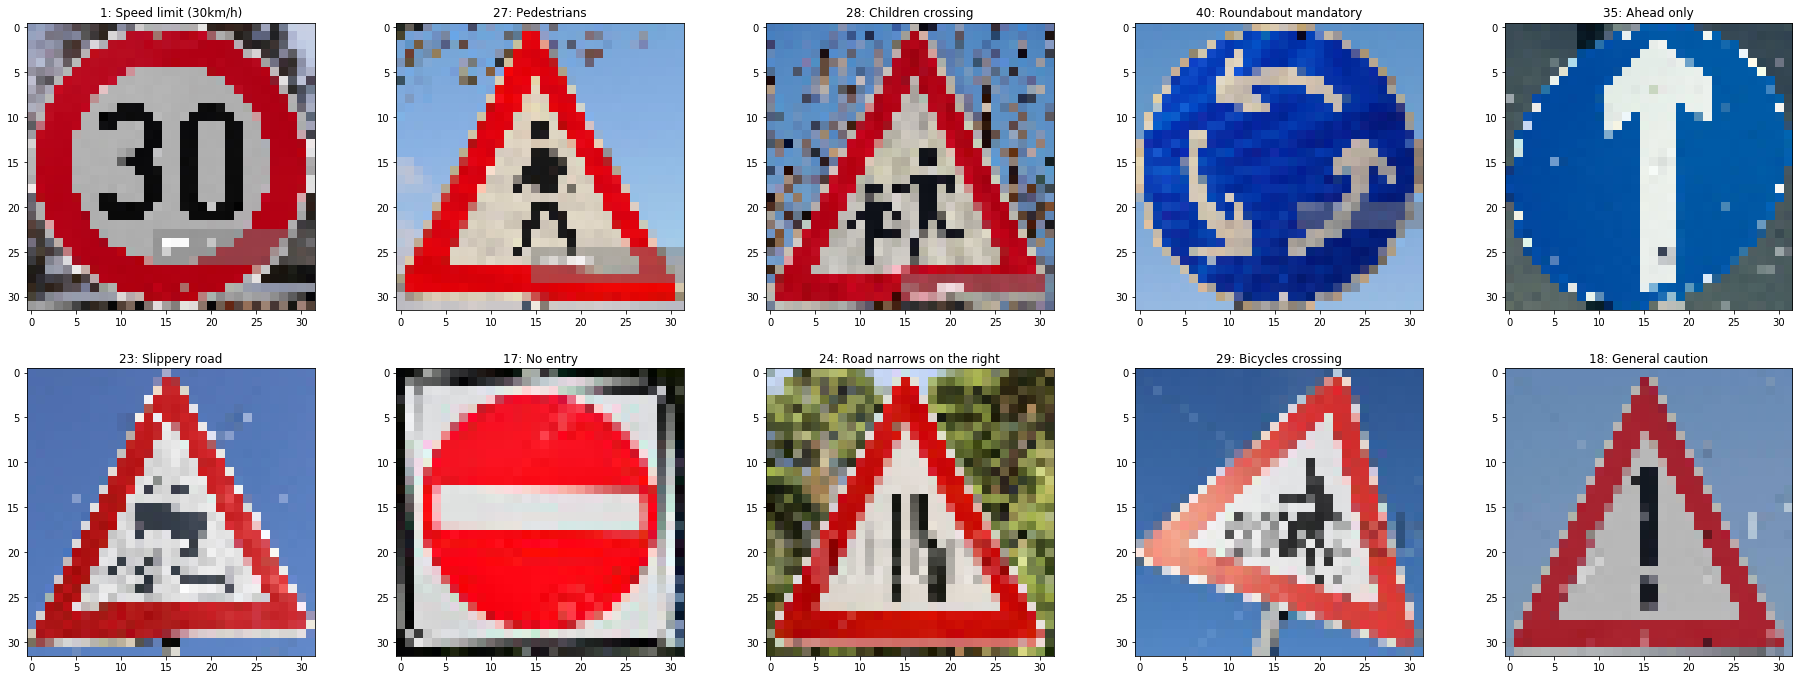

In [99]:
display_X_y_images(X_extra, y_extra, signnames_pd, 0, 10)

In [100]:
X_extra_preprocessed = preprocess_images(X_extra)

100%|██████████| 4/4 [00:00<00:00, 4534.38it/s]


In [101]:
X_extra_preprocessed.min(), X_extra_preprocessed.max()

(-0.52163047, 0.55776751)

### Predict the Sign Type for Each Image

In [102]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

In [103]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    logits_result = sess.run(logits_argmax, feed_dict={x: X_extra_preprocessed, keep_prob: 1.0})

    #print([signname_val_to_name(signnames_pd, x) for x in logits_result])

### Analyze Performance

In [104]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

In [105]:
image_cnt = y_extra.shape[0]
correct_cnt = 0

for i in range(image_cnt):
    if y_extra[i] == logits_result[i]:
        correct_cnt += 1
        
accuracy = float(correct_cnt)/image_cnt
print(accuracy)

0.7


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [106]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

In [107]:
top_logits = tf.nn.top_k(tf.nn.softmax(logits), k=5, name='top_logits')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    top_logits_result = sess.run(top_logits, feed_dict={x: X_extra_preprocessed, keep_prob: 1.0})

logit_vals, label_vals = top_logits_result     
for i in range(y_extra.shape[0]): 
    print("%d: %s" % (i, signname_val_to_name(signnames_pd, y_extra[i])))
    
    curr_logit_vals = logit_vals[i]
    curr_label_vals = label_vals[i]
    for j in range(curr_logit_vals.shape[0]):
        print("\t%.4f\t%s" % (curr_logit_vals[j], signname_val_to_name(signnames_pd, curr_label_vals[j])))
              
    print()

0: Speed limit (30km/h)
	1.0000	Speed limit (30km/h)
	0.0000	Priority road
	0.0000	Go straight or left
	0.0000	Roundabout mandatory
	0.0000	Speed limit (70km/h)

1: Pedestrians
	0.9998	Pedestrians
	0.0001	Ahead only
	0.0001	Road narrows on the right
	0.0000	Traffic signals
	0.0000	Go straight or right

2: Children crossing
	1.0000	Children crossing
	0.0000	Speed limit (120km/h)
	0.0000	Dangerous curve to the right
	0.0000	Ahead only
	0.0000	Bicycles crossing

3: Roundabout mandatory
	0.9947	Keep left
	0.0017	Yield
	0.0009	Go straight or left
	0.0007	End of no passing by vehicles over 3.5 metric tons
	0.0006	Go straight or right

4: Ahead only
	1.0000	Ahead only
	0.0000	Go straight or left
	0.0000	Priority road
	0.0000	Right-of-way at the next intersection
	0.0000	Turn right ahead

5: Slippery road
	0.9539	Bicycles crossing
	0.0421	Road work
	0.0010	Road narrows on the right
	0.0006	Bumpy road
	0.0005	Children crossing

6: No entry
	1.0000	No entry
	0.0000	Bumpy road
	0.0000	Dangerous c

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")